# More mess

In [1]:
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt 
import lyricsgenius
import os
import re
from pathlib import Path


In [24]:
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\final_proj\artist_network.graphml")
# Load the graph
# casting to str() ensures compatibility
G = nx.read_graphml(str(G_path)) 

# Quick check to see if it loaded correctly
print(G) 
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")



target_node_id = 'Britney_Spears' # <--- REPLACE WITH A REAL NODE ID

# Check if the node exists before trying to access it
if target_node_id in G:
    # G.nodes[target_node_id] returns the attribute dictionary for that node
    node_attributes = G.nodes[target_node_id]
    
    print(f"\n--- Attributes for Node '{target_node_id}' ---")
    print(node_attributes)

    # If you want to print them one by one
    print("\n--- Detailed Attributes ---")
    for key, value in node_attributes.items():
        print(f"  {key}: {value}")
else:
    print(f"Node '{target_node_id}' not found in the graph.")

Graph with 4432 nodes and 209375 edges
Number of nodes: 4432
Number of edges: 209375

--- Attributes for Node 'Britney_Spears' ---
{'songs': '["Make Me... (feat. G-Eazy)", "Love Me Down", "I\'m a Slave 4 U", "Me Against the Music - LP Version / Video Mix", "I\'m Not a Girl, Not Yet a Woman", "Circus", "Pretty Girls", "(You Drive Me) Crazy - The Stop Remix!", "Gimme More", "Lucky", "Overprotected - Radio Edit", "Boys", "Toxic", "Work B**ch", "Stronger", "(You Drive Me) Crazy", "...Baby One More Time", "I Wanna Go", "Oops!...I Did It Again"]', 'albums': '["Britney (Digital Deluxe Version)", "Blackout", "...Baby One More Time (Digital Deluxe Version)", "Pretty Girls", "Femme Fatale (Deluxe Version)", "Circus (Deluxe Version)", "Glory (Deluxe Version)", "Oops!... I Did It Again", "Greatest Hits: My Prerogative", "In The Zone", "Britney Jean (Deluxe Version)"]', 'playlists': '[0, 129, 779, 908, 18, 663, 29, 927, 38, 40, 717, 990, 355, 358, 359, 234, 112, 245, 635]', 'num_playlists': 19, 'nu

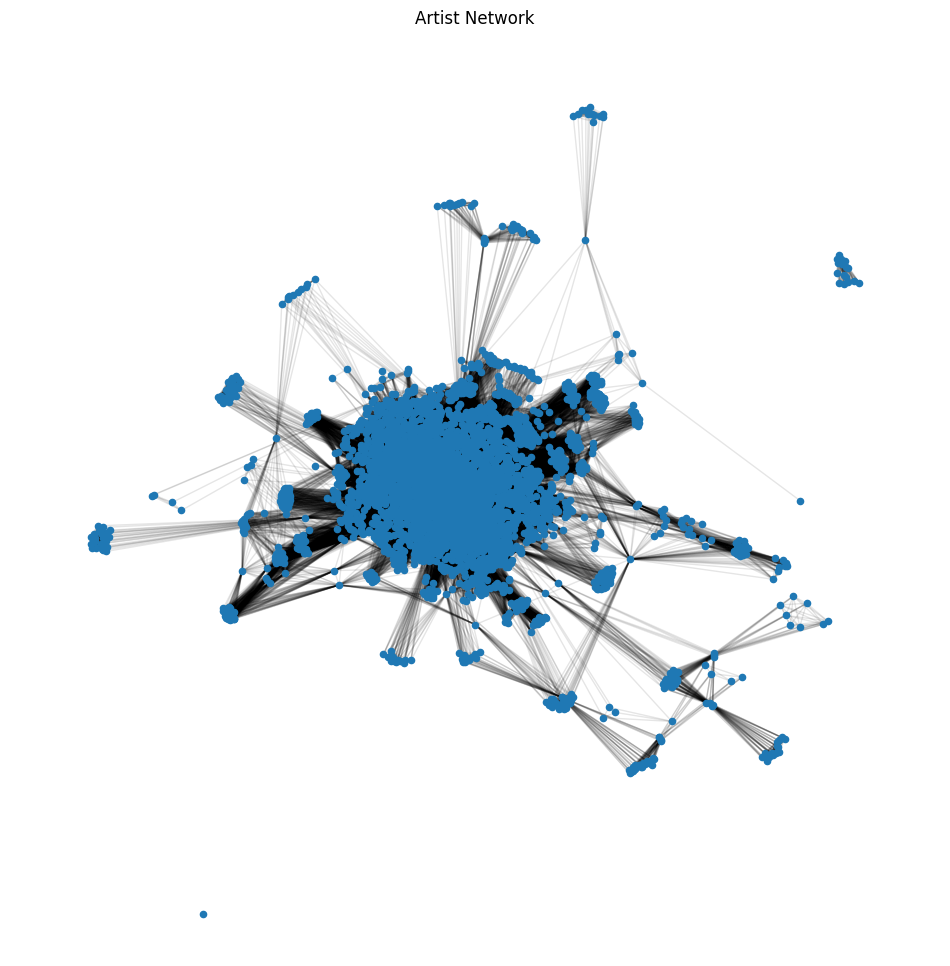

In [25]:
# plot the network
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title("Artist Network")
plt.axis('off')
plt.show()


In [9]:
import networkx as nx
import numpy as np
from tqdm import tqdm  # Import the progress bar library

def get_disparity_backbone(G, alpha_threshold=0.05, test_limit=None):
    """
    Args:
        G: The graph
        alpha_threshold: The significance level (0.05 is standard)
        test_limit: If set to an integer (e.g., 100), only processes that many nodes.
    """
    B = nx.Graph() # The new backbone graph
    
    # Get list of nodes
    nodes_to_process = list(G.nodes())
    
    # If we are testing, slice the list
    if test_limit:
        print(f"⚠️ TEST MODE: Processing only first {test_limit} nodes...")
        nodes_to_process = nodes_to_process[:test_limit]
    
    # Iterate over nodes with a progress bar
    for u in tqdm(nodes_to_process, desc="Computing backbone"):
        k = G.degree(u)
        
        if k > 1:
            # Sum of weights for node u
            sum_w = sum(d['weight'] for _, _, d in G.edges(u, data=True))
            
            for v, data in G[u].items():
                w = data['weight']
                p_ij = float(w) / sum_w
                
                # Calculate alpha (significance)
                alpha_ij = (1 - p_ij) ** (k - 1)
                
                # If significant, keep the edge
                if alpha_ij < alpha_threshold:
                    B.add_edge(u, v, weight=w)
                    
                    # Copy node attributes (lyrics, etc.)
                    # We use G.nodes[u] to ensure we get the data from the original graph
                    if u not in B:
                        B.add_node(u, **G.nodes[u])
                    if v not in B:
                        B.add_node(v, **G.nodes[v])
    
    return B

# --- HOW TO RUN IT ---

# 1. TEST RUN (First 500 nodes)
# This lets you see the progress bar speed and check if it crashes.
# print("Starting test run...")
# G_test = get_disparity_backbone(G, alpha_threshold=0.05, test_limit=None)
# print(f"Test run complete. Backbone edges found: {G_test.number_of_edges()}")

# 2. FULL RUN (Uncomment below when ready)
print("Starting full run...")
G_backbone = get_disparity_backbone(G, alpha_threshold=0.005)
print(f"Full run complete. Backbone nodes: {G_backbone.number_of_nodes()}, Edges: {G_backbone.number_of_edges()}")

Starting full run...


Computing backbone: 100%|██████████| 4432/4432 [00:00<00:00, 8727.54it/s] 

Full run complete. Backbone nodes: 167, Edges: 569


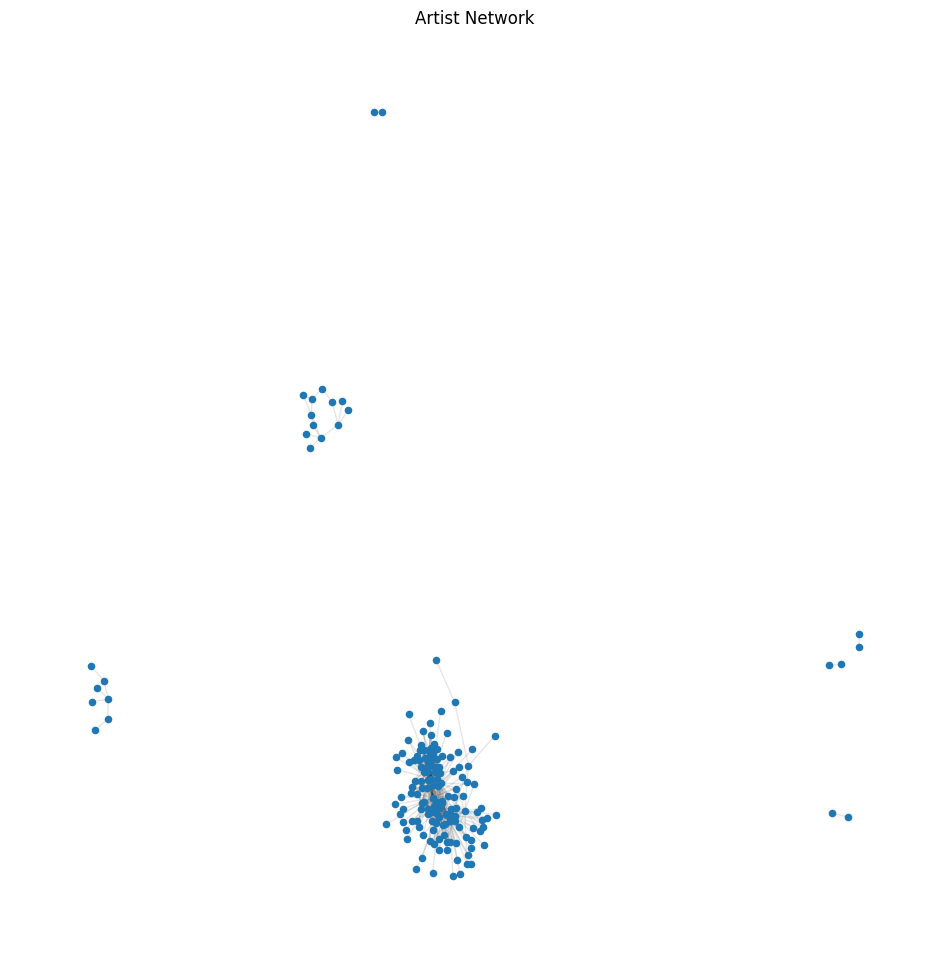

In [12]:
# plot the network
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_backbone, k=0.1)  # positions for all nodes
nx.draw_networkx_nodes(G_backbone, pos, node_size=20)
nx.draw_networkx_edges(G_backbone, pos, alpha=0.1)
plt.title("Artist Network")
plt.axis('off')
plt.show()


### embedding

Reloading graph to ensure lyrics are present...
Debug Check - Node: Missy_Elliott
Debug Check - Has Lyrics? True
🚀 Running on: cpu
Gathering lyrics...
Nodes sent to AI: 4432
Encoding...


Batches: 100%|██████████| 139/139 [02:50<00:00,  1.23s/it]


Comparing edges...


100%|██████████| 209375/209375 [01:07<00:00, 3113.34it/s]


✨ Pearson Correlation: 0.0564


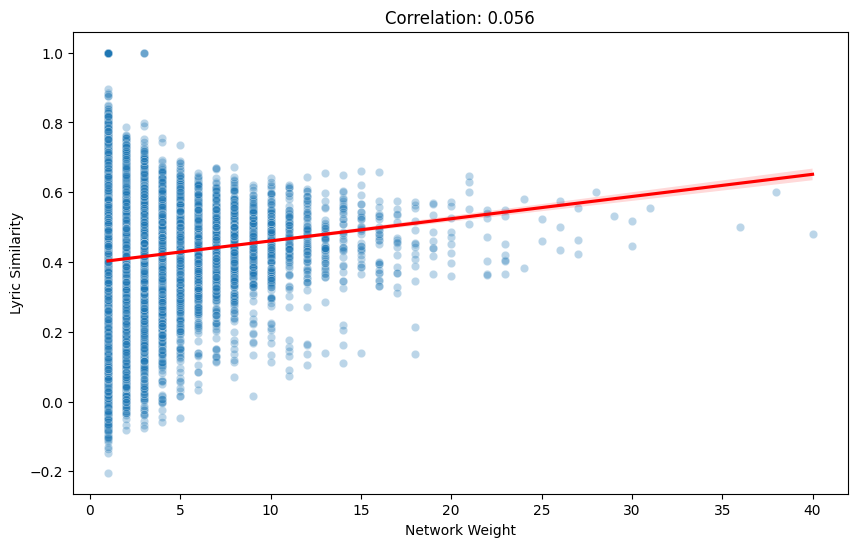

In [14]:
import networkx as nx
from pathlib import Path
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- 1. RELOAD DATA (To ensure we have lyrics) ---
# Update this path if needed
G_path = Path(r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\final_proj\artist_network.graphml")

print("Reloading graph to ensure lyrics are present...")
G = nx.read_graphml(str(G_path))

# # --- 2. CREATE A CORRECT TEST SLICE ---
# # We take the first 200 nodes, but use .subgraph() to KEEP the lyrics
# print("Creating a small test graph (preserving attributes)...")
# test_nodes = list(G_full.nodes())[:200]
# G = G_full.subgraph(test_nodes).copy()

# Check one node to be 100% sure
first_node = list(G.nodes())[0]
print(f"Debug Check - Node: {first_node}")
print(f"Debug Check - Has Lyrics? {'lyrics' in G.nodes[first_node]}")

# --- 3. SETUP AI ---
def get_device():
    if torch.cuda.is_available(): return "cuda"
    if torch.backends.mps.is_available(): return "mps"
    return "cpu"

device = get_device()
print(f"🚀 Running on: {device}")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# --- 4. PREPARE LYRICS ---
node_ids = []
lyrics_list = []

print("Gathering lyrics...")
for node in G.nodes():
    # Fetch lyrics, convert to string safely
    raw_text = str(G.nodes[node].get('lyrics', ''))
    
    # Check length (str(None) is 4 chars, so >5 filters out empty/None)
    if len(raw_text) > 5:
        node_ids.append(node)
        lyrics_list.append(raw_text[:2000])

print(f"Nodes sent to AI: {len(node_ids)}")

if len(node_ids) == 0:
    raise ValueError("Still no lyrics! Check the 'Debug Check' print above.")

# --- 5. ENCODE & ANALYZE ---
print("Encoding...")
embeddings = model.encode(lyrics_list, show_progress_bar=True, device=device)
embedding_dict = {node: emb for node, emb in zip(node_ids, embeddings)}

print("Comparing edges...")
data_points = []

for u, v, data in tqdm(G.edges(data=True)):
    if u in embedding_dict and v in embedding_dict:
        sim = cosine_similarity([embedding_dict[u]], [embedding_dict[v]])[0][0]
        
        data_points.append({
            'Network Weight': data['weight'], 
            'Lyric Similarity': sim
        })

# --- 6. PLOT ---
df = pd.DataFrame(data_points)

if not df.empty:
    corr = df['Network Weight'].corr(df['Lyric Similarity'])
    print(f"✨ Pearson Correlation: {corr:.4f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Network Weight', y='Lyric Similarity', alpha=0.3)
    sns.regplot(data=df, x='Network Weight', y='Lyric Similarity', scatter=False, color='red')
    plt.title(f"Correlation: {corr:.3f}")
    plt.show()
else:
    print("Not enough edges in this small test slice to plot.")

C:\Users\Madsl\AppData\Local\Temp\ipykernel_26816\376305415.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Weight Bin', y='Lyric Similarity', data=df, order=order, palette="Blues")


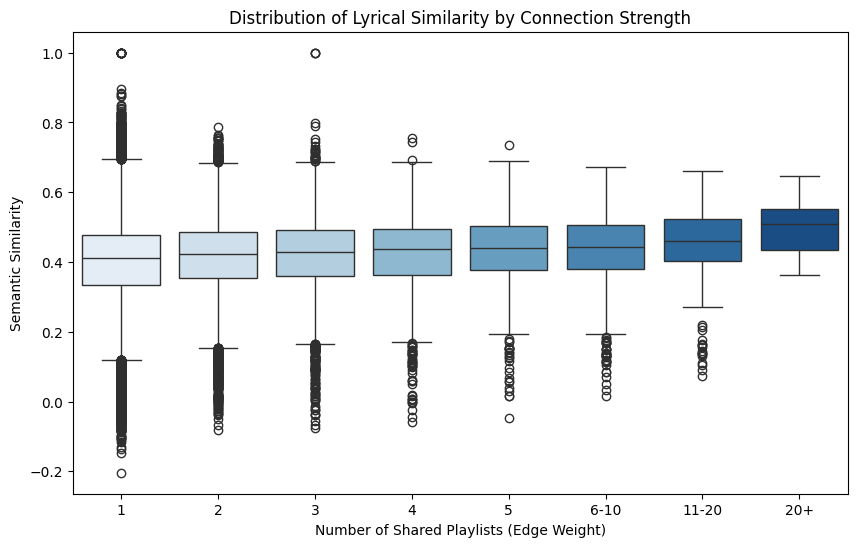

In [17]:
import numpy as np

# 1. Create Bins for the Weight
# We group weights: 1, 2, 3, 4, 5, 6-10, 11-20, 20+
def bin_weight(w):
    if w <= 5: return str(int(w))
    elif w <= 10: return "6-10"
    elif w <= 20: return "11-20"
    else: return "20+"

df['Weight Bin'] = df['Network Weight'].apply(bin_weight)

# Define order for the plot so it doesn't sort alphabetically (1, 10, 2...)
order = ['1', '2', '3', '4', '5', '6-10', '11-20', '20+']

# 2. Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Weight Bin', y='Lyric Similarity', data=df, order=order, palette="Blues")
plt.title("Distribution of Lyrical Similarity by Connection Strength")
plt.xlabel("Number of Shared Playlists (Edge Weight)")
plt.ylabel("Semantic Similarity")
plt.show()

In [18]:
# --- REBUILD DATAFRAME WITH NAMES ---
print("Re-building dataframe with artist names...")
data_points = []

# Re-run just the comparison loop (very fast, no AI involved)
for u, v, data in tqdm(G.edges(data=True)):
    if u in embedding_dict and v in embedding_dict:
        # We assume cosine_similarity is imported
        # If you get an error, re-import sklearn
        from sklearn.metrics.pairwise import cosine_similarity
        
        sim = cosine_similarity(
            [embedding_dict[u]], 
            [embedding_dict[v]]
        )[0][0]
        
        data_points.append({
            'Artist A': u,
            'Artist B': v,  # <--- Adding names back in!
            'Network Weight': data['weight'], 
            'Lyric Similarity': sim
        })

df = pd.DataFrame(data_points)

# --- NOW FIND THE COUPLES ---
weirdest_pair = df[df['Network Weight'] > 15].sort_values('Lyric Similarity').head(1)
best_match = df[df['Network Weight'] > 15].sort_values('Lyric Similarity', ascending=False).head(1)

print("\n--- THE WEIRDEST COUPLE (High Co-occurrence, Different Lyrics) ---")
print(weirdest_pair[['Artist A', 'Artist B', 'Network Weight', 'Lyric Similarity']].to_string(index=False))

print("\n--- THE PERFECT MATCH (High Co-occurrence, Similar Lyrics) ---")
print(best_match[['Artist A', 'Artist B', 'Network Weight', 'Lyric Similarity']].to_string(index=False))

Re-building dataframe with artist names...


100%|██████████| 209375/209375 [01:04<00:00, 3227.76it/s]



--- THE WEIRDEST COUPLE (High Co-occurrence, Different Lyrics) ---
     Artist A         Artist B  Network Weight  Lyric Similarity
Calvin_Harris The_Chainsmokers              18          0.136547

--- THE PERFECT MATCH (High Co-occurrence, Similar Lyrics) ---
      Artist A Artist B  Network Weight  Lyric Similarity
Kendrick_Lamar   Eminem              16          0.656812


### Noise correction

In [36]:
import networkx as nx
import math
from scipy.stats import poisson

from joblib import Parallel, delayed

def noise_corrected_backbone_fast(G, alpha=0.005, n_jobs=-1, weight='weight'):
    """
    Compute Noise-Corrected Backbone using parallel processing and scipy.
    
    Parameters:
    -----------
    G : networkx.Graph
        Weighted graph (edges must have 'weight' attribute).
    alpha : float
        Significance level for edge retention.
    n_jobs : int
        Number of parallel jobs (-1 = all cores).
    weight : str
        Edge attribute to use as weight.
    
    Returns:
    --------
    backbone : networkx.Graph
        Backbone graph with significant edges only.
    """
    backbone = nx.Graph()
    backbone.add_nodes_from(G.nodes(data=True))

    # Precompute node strengths and total weight
    strength = {node: sum(data[weight] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}
    total_weight = G.size(weight=weight)

    edges = list(G.edges(data=True))

    def process_edge(u, v, data):
        w = data[weight]
        expected = (strength[u] * strength[v]) / (2 * total_weight)
        if expected > 0:
            p_value = poisson.sf(w - 1, expected)  # Survival function
        else:
            p_value = 0.0
        return (u, v, w) if p_value < alpha else None

    # Parallel processing
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(process_edge)(u, v, data) for u, v, data in edges)

    # Add significant edges
    for res in results:
        if res:
            u, v, w = res
            backbone.add_edge(u, v, weight=w)
            
            # add all attributes of the nodes to the backbone
            for attr, value in G.nodes[u].items():
                backbone.nodes[u][attr] = value
            for attr, value in G.nodes[v].items():
                backbone.nodes[v][attr] = value
            # add all attributes of the edge to the backbone
            for attr, value in G[u][v].items():
                backbone[u][v][attr] = value
            
    return backbone
# Usage
backbone_noise_cor = noise_corrected_backbone_fast(G, alpha=0.01)
gcc_noise_cor = max(nx.connected_components(backbone_noise_cor), key=len)
G_nc = backbone_noise_cor.subgraph(gcc_noise_cor).copy()

print(G_nc)
# plot the network


Graph with 4029 nodes and 40488 edges


Debug Check - Node: Missy_Elliott
Debug Check - Has Lyrics? True
🚀 Running on: cpu
Gathering lyrics...
Nodes sent to AI: 4029
Encoding...


Batches: 100%|██████████| 126/126 [02:53<00:00,  1.37s/it]


Comparing edges...


100%|██████████| 40488/40488 [00:13<00:00, 2999.15it/s]


✨ Pearson Correlation: 0.0916


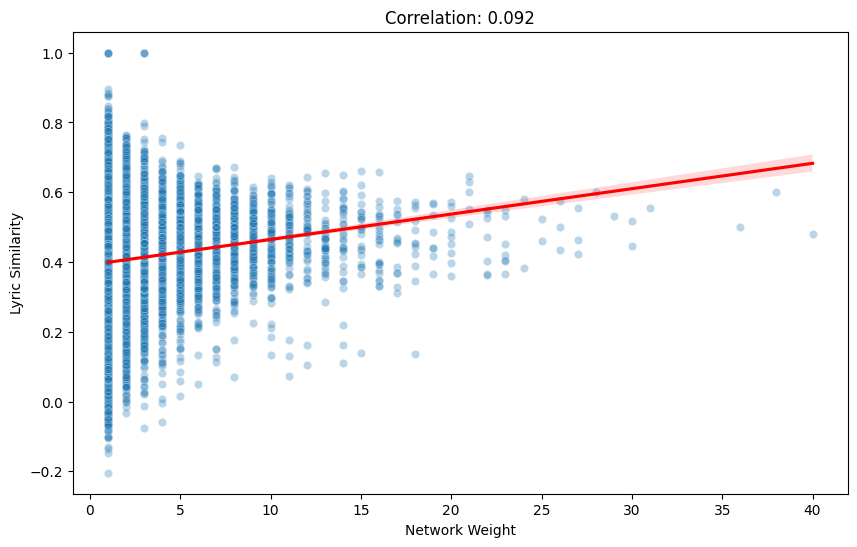

In [37]:

# Check one node to be 100% sure
first_node = list(G_nc.nodes())[0]
print(f"Debug Check - Node: {first_node}")
print(f"Debug Check - Has Lyrics? {'lyrics' in G.nodes[first_node]}")

# --- 3. SETUP AI ---
def get_device():
    if torch.cuda.is_available(): return "cuda"
    if torch.backends.mps.is_available(): return "mps"
    return "cpu"

device = get_device()
print(f"🚀 Running on: {device}")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# --- 4. PREPARE LYRICS ---
node_ids = []
lyrics_list = []

print("Gathering lyrics...")
for node in G_nc.nodes():
    # Fetch lyrics, convert to string safely
    raw_text = str(G_nc.nodes[node].get('lyrics', ''))
    
    # Check length (str(None) is 4 chars, so >5 filters out empty/None)
    if len(raw_text) > 5:
        node_ids.append(node)
        lyrics_list.append(raw_text[:2000])

print(f"Nodes sent to AI: {len(node_ids)}")

if len(node_ids) == 0:
    raise ValueError("Still no lyrics! Check the 'Debug Check' print above.")

# --- 5. ENCODE & ANALYZE ---
print("Encoding...")
embeddings = model.encode(lyrics_list, show_progress_bar=True, device=device)
embedding_dict = {node: emb for node, emb in zip(node_ids, embeddings)}

print("Comparing edges...")
data_points = []

for u, v, data in tqdm(G_nc.edges(data=True)):
    if u in embedding_dict and v in embedding_dict:
        sim = cosine_similarity([embedding_dict[u]], [embedding_dict[v]])[0][0]
        
        data_points.append({
            'Network Weight': data['weight'], 
            'Lyric Similarity': sim
        })

# --- 6. PLOT ---
df = pd.DataFrame(data_points)

if not df.empty:
    corr = df['Network Weight'].corr(df['Lyric Similarity'])
    print(f"✨ Pearson Correlation: {corr:.4f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Network Weight', y='Lyric Similarity', alpha=0.3)
    sns.regplot(data=df, x='Network Weight', y='Lyric Similarity', scatter=False, color='red')
    plt.title(f"Correlation: {corr:.3f}")
    plt.show()
else:
    print("Not enough edges in this small test slice to plot.")

In [35]:

print("building dataframe with artist names...")
data_points = []

# Re-run just the comparison loop (very fast, no AI involved)
for u, v, data in tqdm(G_nc.edges(data=True)):
    if u in embedding_dict and v in embedding_dict:
        # We assume cosine_similarity is imported
        # If you get an error, re-import sklearn
        from sklearn.metrics.pairwise import cosine_similarity
        
        sim = cosine_similarity(
            [embedding_dict[u]], 
            [embedding_dict[v]]
        )[0][0]
        
        data_points.append({
            'Artist A': u,
            'Artist B': v,  # <--- Adding names back in!
            'Network Weight': data['weight'], 
            'Lyric Similarity': sim
        })

df = pd.DataFrame(data_points)

# --- NOW FIND THE COUPLES ---
weirdest_pair = df[df['Network Weight'] > 15].sort_values('Lyric Similarity').head(1)
best_match = df[df['Network Weight'] > 15].sort_values('Lyric Similarity', ascending=False).head(1)

print("\n--- THE WEIRDEST COUPLE (High Co-occurrence, Different Lyrics) ---")
print(weirdest_pair[['Artist A', 'Artist B', 'Network Weight', 'Lyric Similarity']].to_string(index=False))

print("\n--- THE PERFECT MATCH (High Co-occurrence, Similar Lyrics) ---")
print(best_match[['Artist A', 'Artist B', 'Network Weight', 'Lyric Similarity']].to_string(index=False))

building dataframe with artist names...


100%|██████████| 20222/20222 [00:06<00:00, 3121.22it/s]


--- THE WEIRDEST COUPLE (High Co-occurrence, Different Lyrics) ---
     Artist A         Artist B  Network Weight  Lyric Similarity
Calvin_Harris The_Chainsmokers              18          0.136547

--- THE PERFECT MATCH (High Co-occurrence, Similar Lyrics) ---
      Artist A Artist B  Network Weight  Lyric Similarity
Kendrick_Lamar   Eminem              16          0.656812


### Community sentiment

In [38]:
import community.community_louvain as community_louvain # pip install python-louvain
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

In [40]:


# 1. SETUP VADER
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')
    
sia = SentimentIntensityAnalyzer()

# 2. GET COMMUNITIES
# We run Louvain on the backbone (cleaner) or the full graph.
# Using G_full (or just G) is usually fine for this.
print("Detecting communities (Louvain)...")
partition = community_louvain.best_partition(G_nc, weight='weight')

# Count how many artists in each community to filter out tiny ones
from collections import Counter
counts = Counter(partition.values())
# Keep only communities with at least 50 artists (to be statistically relevant)
big_communities = [c for c, count in counts.items() if count > 50]

print(f"Found {len(counts)} communities. Analyzing {len(big_communities)} major ones.")

# 3. CALCULATE SENTIMENT PER ARTIST
data = []

print("Analyzing sentiment...")
for node in tqdm(G_nc.nodes()):
    # Only process if node is in a big community
    comm_id = partition[node]
    if comm_id in big_communities:
        
        # Get Lyrics
        text = str(G_nc.nodes[node].get('lyrics', ''))
        
        # If we have lyrics, score them
        if len(text) > 50:
            # Polarity scores returns a dict: {'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound': 0.9}
            # We care about 'compound' (-1 to 1)
            score = sia.polarity_scores(text)['compound']
            
            data.append({
                'Artist': node,
                'Community': f"Cluster {comm_id}",
                'Sentiment': score
            })

df_sentiment = pd.DataFrame(data)

# 4. SORT COMMUNITIES BY AVERAGE HAPPINESS
# This makes the plot look organized (Sad -> Happy)
order = df_sentiment.groupby('Community')['Sentiment'].median().sort_values().index

# 5. VISUALIZE
plt.figure(figsize=(12, 6))
sns.boxplot(x='Community', y='Sentiment', data=df_sentiment, order=order, palette="RdBu")
plt.title("Emotional Distribution of Musical Genres (Communities)")
plt.ylabel("Sentiment Score (-1 = Negative, +1 = Positive)")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', alpha=0.5) # The "Neutral" line
plt.show()

# 6. PRINT SUMMARY
print("\n--- COMMUNITY EMOTIONAL PROFILES ---")
stats = df_sentiment.groupby('Community')['Sentiment'].describe()[['count', 'mean', 'std']]
print(stats.sort_values(by='mean'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Madsl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Detecting communities (Louvain)...
Found 31 communities. Analyzing 24 major ones.
Analyzing sentiment...


  0%|          | 4/4029 [01:18<21:54:44, 19.60s/it]


KeyboardInterrupt: 